# 1.Librerías

In [ ]:
%pip install lightgbm==4.4.0
%pip install optuna==3.6.1

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

# 2.Datos

In [3]:
#seteo carpeta de trabajo y archivo
# dataset_path = '/home/ingceciliaconde/buckets/b1/datasets'
# modelos_path = '/home/ingceciliaconde/buckets/b1/datasets/modelos'
# db_path = '/home/ingceciliaconde/buckets/b1/datasets/db'
# exp_path ='/home/ingceciliaconde/buckets/b1/exp'
# dataset_file = 'competencia_02.csv.gz'


In [4]:
#path de trabajo local para pruebas
#seteo carpeta de trabajo y archivo
dataset_path = 'C:/Users/mconde/Documents/DMEYF/Competencia_01'
db_path = 'C:/Users/mconde/Documents/DMEYF/Competencia_01'
modelos_path = 'C:/Users/mconde/Documents/DMEYF/Competencia_01'
dataset_file = 'competencia_01.csv'


In [5]:
print(f"{dataset_path}/{dataset_file}")



C:/Users/mconde/Documents/DMEYF/Competencia_01/competencia_01.csv


In [6]:
# Lectura de datos.
data= pd.read_csv(f"{dataset_path}/{dataset_file}")


In [7]:
#semillas y valores de ganancia
semillas=[100183,200003,300017,700001,800011]
ganancia_acierto = 273000
costo_estimulo = 7000

In [15]:
#meses
mes_train_all = [201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908,
                 201909, 201910, 201911, 201912, 202001, 202002, 202003, 202004,
                 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106]

mes_train_4 = [202101, 202102, 202103, 202104 ]
mes_train_6 = [202101, 202102, 202103, 202104, 202105, 202106]
mes_train_12 = [202006, 202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106]
mes_test = 202108

In [16]:
mes_train=mes_train_4 #si uso 6 meses, cambiar a mes_train_6 y si uso all, cambiar a mes_train_all

## Darle valor a las clases

In [17]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

En particular, sumaremos la clase BAJA+1, que es estructuralmente muy similar a BAJA+2, para aumentar los casos positivos. Luego, compararemos los resultados obtenidos con los de la clase con la que hemos estado trabajando hasta ahora.

In [18]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0) # solo baja +2
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1) #ambas bajas

In [19]:
#filtrar por baja + 2 y mostrar clase ternaria clase binaria
data[data['clase_ternaria'] == 'BAJA+2'][['clase_ternaria', 'clase_binaria1', 'clase_binaria2']].head()


,clase_ternaria,clase_binaria1,clase_binaria2
1047,BAJA+2,1,1
1651,BAJA+2,1,1
1870,BAJA+2,1,1
1920,BAJA+2,1,1
2039,BAJA+2,1,1


# 3.Separa Test y Train

In [20]:
train_data = data[data['foto_mes'].isin(mes_train)] # train_data = data[data['foto_mes'] == mes_train]
#test_data = data[data['foto_mes'] == mes_test]
test_data = data[data['foto_mes'] == 202106] #solo para hacer el script, en la competencia se usará 202108

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1'] #SOLO BAJA+2
y_train_binaria2 = train_data['clase_binaria2'] #TODAS LAS BAJAS
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

# Corre el modelo

In [36]:
#8. Volvemos a leer el modelo.
#model_lgb = lgb.Booster(model_file= modelos_path + 'lgbm_{}_{}.txt'.format(cantidad_meses_train,ventana))

In [24]:
import os
import re

# Definimos el patrón de nombre que esperamos para los archivos de modelos
pattern = re.compile(r'^lgb_v5_semilla\d+_\d+_\d+\.txt$') #modificar segun nomrbre de archivo

# Obtén la lista de archivos de modelos en el directorio que coinciden con el patrón
model_files = [f for f in os.listdir(dataset_path) if pattern.match(f)]
print(model_files)

['lgb_v5_semilla100183_12_3.txt', 'lgb_v5_semilla100183_6_3.txt', 'lgb_v5_semilla200003_12_3.txt', 'lgb_v5_semilla200003_6_3.txt', 'lgb_v5_semilla300017_12_3.txt', 'lgb_v5_semilla300017_6_3.txt', 'lgb_v5_semilla700001_12_3.txt', 'lgb_v5_semilla700001_6_3.txt', 'lgb_v5_semilla800011_12_3.txt', 'lgb_v5_semilla800011_6_3.txt']


In [63]:
import pandas as pd
import numpy as np
import os
import time

# Inicialización de DataFrame para almacenar todas las predicciones
df_predicciones = pd.DataFrame()

# Bucle sobre cada archivo de modelo para cargar y predecir
for model_file in model_files:
    model_path = os.path.join(dataset_path, model_file)
    model_lgb = lgb.Booster(model_file=model_path)
    
    # Copia X_test para evitar añadir múltiples veces la columna 'Probabilidad'
    X_test_copy = X_test.copy()
    
    # Predecir con el modelo cargado y almacenar las probabilidades
    predicciones = model_lgb.predict(X_test_copy)
    df_predicciones[model_file] = predicciones



In [64]:
#backtesting
train_data = data[data['foto_mes'] == 202103]
test_data = data[data['foto_mes'] == 202104]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

In [65]:
y_test_binaria1

3         0
9         0
15        0
21        0
27        0
         ..
981921    1
981926    0
981932    0
981936    0
981941    0
Name: clase_binaria1, Length: 164090, dtype: int32

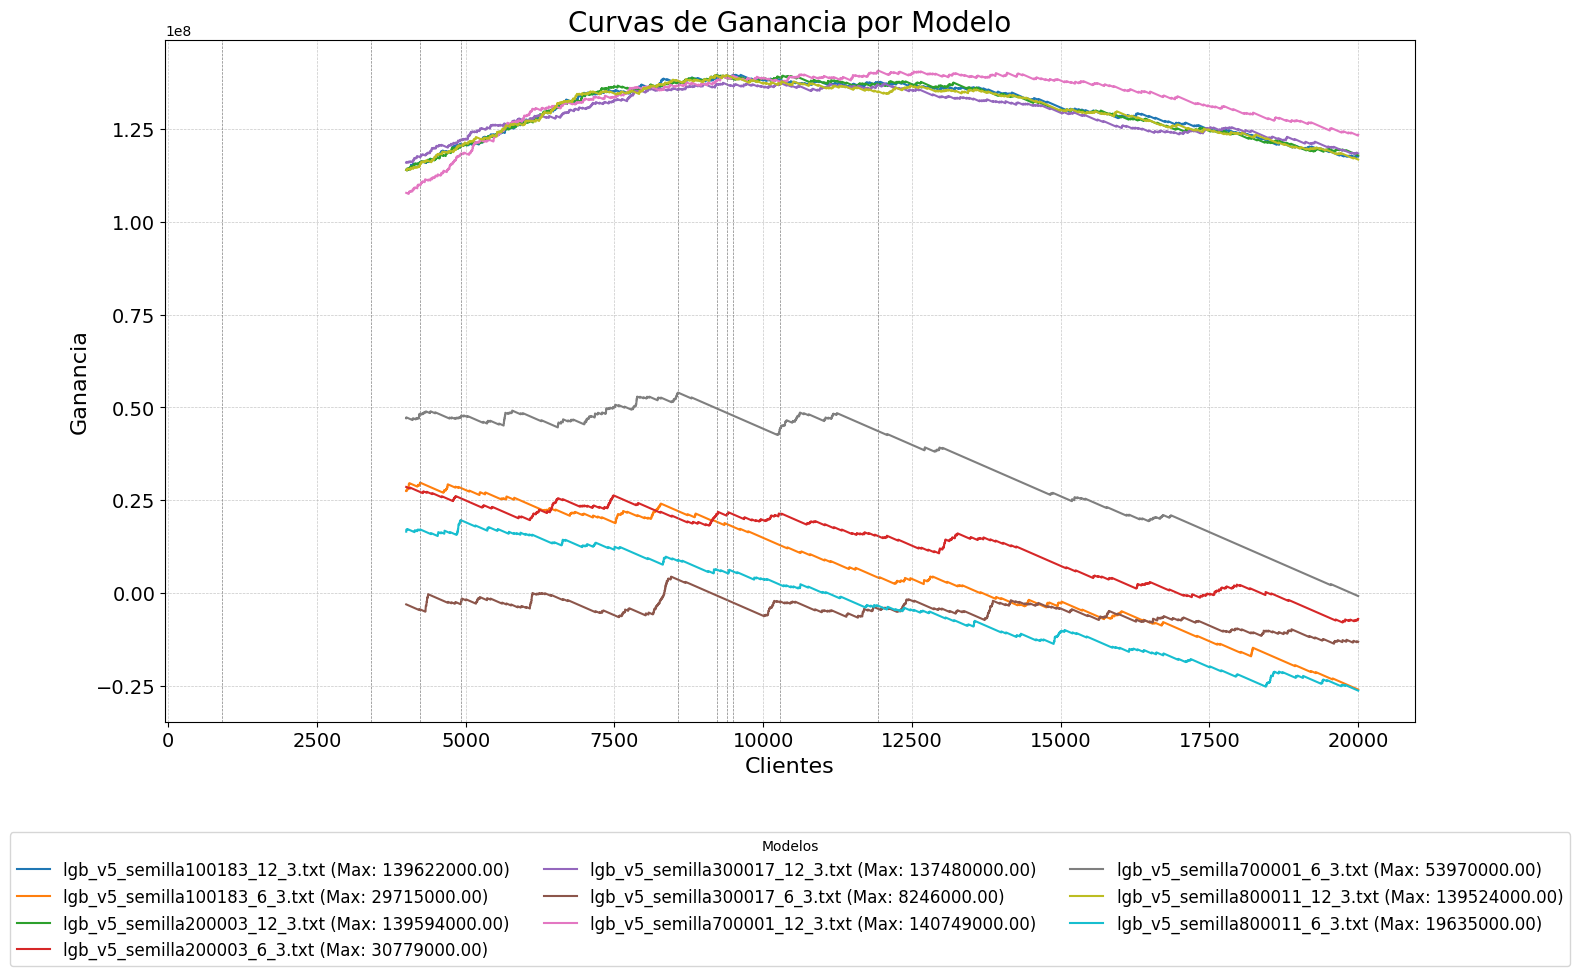

In [70]:
modelos = df_predicciones.columns  # Todas las columnas de predicciones en el DataFrame
ganancias_por_modelo = []  # Almacenar resultados de cada modelo
# Parámetros comunes
piso_envios = 4000
techo_envios = 20000

# Crear una figura más grande para incluir todas las curvas
plt.figure(figsize=(16, 10))  # Tamaño del gráfico ajustado (ancho x alto)

# Iterar sobre cada modelo en df_predicciones
for modelo in modelos:
    # Ordenar las predicciones y calcular ganancias
    idx = np.argsort(df_predicciones[modelo].values)[::-1]
    y_pred_lgm = df_predicciones.iloc[idx][modelo]
    ganancia = np.where(y_test_binaria1 == 1, ganancia_acierto, 0) - np.where(y_test_binaria1 == 0, costo_estimulo, 0)
    ganancia = ganancia[idx]
    ganancia_cum = np.cumsum(ganancia)

    # Determinar la ganancia máxima y el índice correspondiente
    ganancia_max = ganancia_cum.max()
    gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

    # Almacenar resultados para análisis posterior
    ganancias_por_modelo.append({
        'modelo': modelo,
        'ganancia_max': ganancia_max,
        'gan_max_idx': gan_max_idx,
        'ganancia_cum': ganancia_cum
    })

    # Graficar la curva de ganancias para el modelo actual
    plt.plot(
        range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios),
        ganancia_cum[piso_envios:techo_envios],
        label=f'{modelo} (Max: {ganancia_max:.2f})'
    )
    plt.axvline(x=gan_max_idx, color='gray', linestyle='--', linewidth=0.5)

# Personalizar el gráfico
plt.title('Curvas de Ganancia por Modelo', fontsize=20)  # Título más grande
plt.xlabel('Clientes', fontsize=16)
plt.ylabel('Ganancia', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Mover la leyenda debajo del gráfico
plt.legend(
    loc='upper center',              # Posición en la parte superior central
    bbox_to_anchor=(0.5, -0.15),     # Coordenadas relativas fuera del gráfico
    title='Modelos',
    fontsize=12,
    ncol=3                           # Mostrar la leyenda en varias columnas
)

plt.tight_layout()  # Ajustar para evitar solapamientos
plt.show()


        